In [1]:
# -*- coding: utf-8 -*-
from __future__ import print_function
from __future__ import division
import datetime

%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
import pandas as pd
import numpy as np

In [3]:
dfo = pd.read_csv('../data/processed/observations.csv', parse_dates=['event_date'])
dfc = pd.read_csv('../data/processed/climate.csv', parse_dates=['dt'])

## Resampling and plotting observation data

In [4]:
def resample_cumulative_event_count(df, veg_type, event_type, start_date='2016-01-01', end_date='2016-12-31'):
    # slicing, sorting, and reindexing DataFrame
    ts = df[(df['veg_type']==veg_type) & (df['event_type']==event_type)][['event_date']]
    ts = ts.sort_values(by='event_date')
    ts.set_index('event_date', inplace=True)
    # adding dummy count value (count of observations on that date), which will serve for the summation
    ts['count']=1
    # resampling on a daily basis day by counting events, and getting the cumulative sum of events day after day
    ts = ts.resample('D').count().interpolate().cumsum()
    # reindexing over the whole year (resampling by count prior to reindexing is needed to eliminate duplicate indices)
    # 'ffill' propagates the latest known value forwards into the Series,
    # and fillna ensures that the first values are 0 instead of NaN
    ts = ts.reindex(pd.date_range('2016-01-01', '2016-12-31'), method='ffill').fillna(0)
    return ts

In [5]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

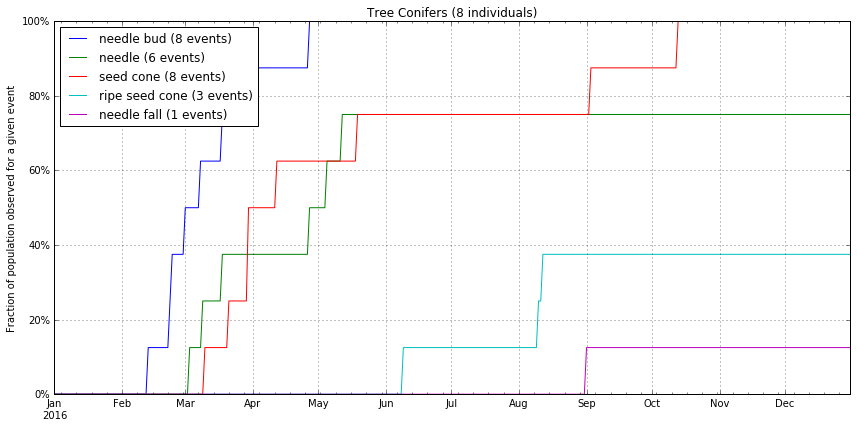

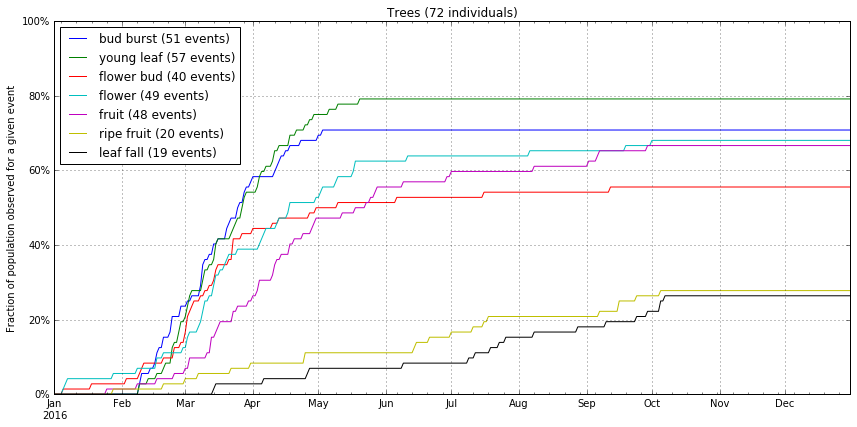

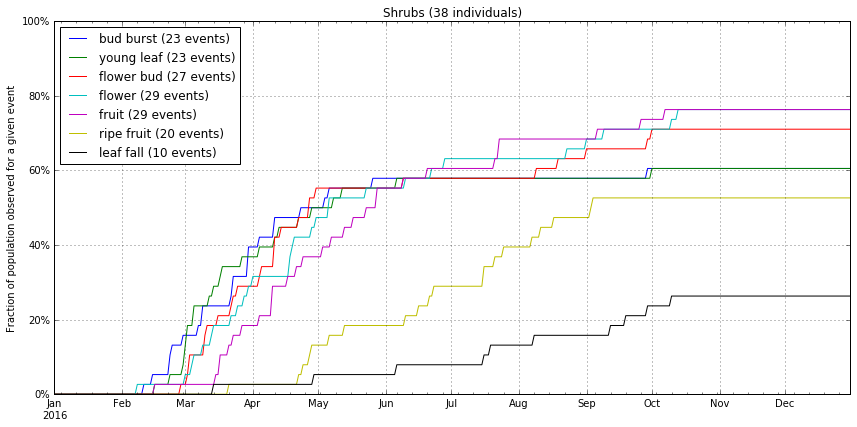

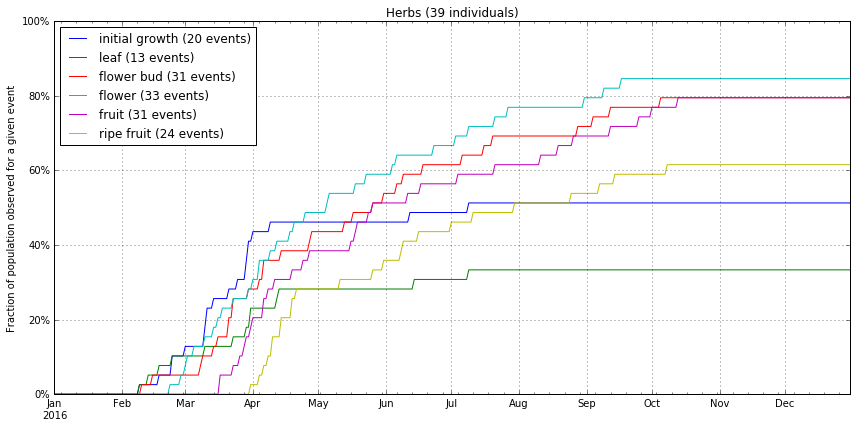

In [6]:
vegtypes = dfo.veg_type.unique()

for vegtype in vegtypes:
    fig = plt.figure(figsize=(12,6))
    ax = fig.gca()
    
    events = dfo[dfo['veg_type']==vegtype].event_type.unique()
    num_individuals = len(dfo[dfo.veg_type==vegtype].species_id.unique())
    for event in events:
        ts = resample_cumulative_event_count(dfo, veg_type=vegtype, event_type=event)
        ts['%s (%d events)' % (event.replace('_', ' '.title()), ts.max())] = ts['count']
        del ts['count']
        (ts/num_individuals*100).plot(ax=ax, legend=False)
        # fix legend location
        patches, labels = ax.get_legend_handles_labels()
        ax.legend(patches, labels, loc='upper left')
        # format ytick labels to show %
        ytickformat = '%.0f%%'
        yticks = mtick.FormatStrFormatter(ytickformat)
        ax.yaxis.set_major_formatter(yticks)
    ax.set_title(vegtype.replace('_', ' ').title() + 's ' + '(%d individuals)' % num_individuals)
    ax.set_ylabel('Fraction of population observed for a given event')
    ax.set_ylim([0,100])
    ax.grid(True)
    fig.tight_layout()

plt.show();

## Resampling and plotting climate data

### Rain

Is the rain index reliable? Let's plot monthly precipitation graphs over the year for all schools

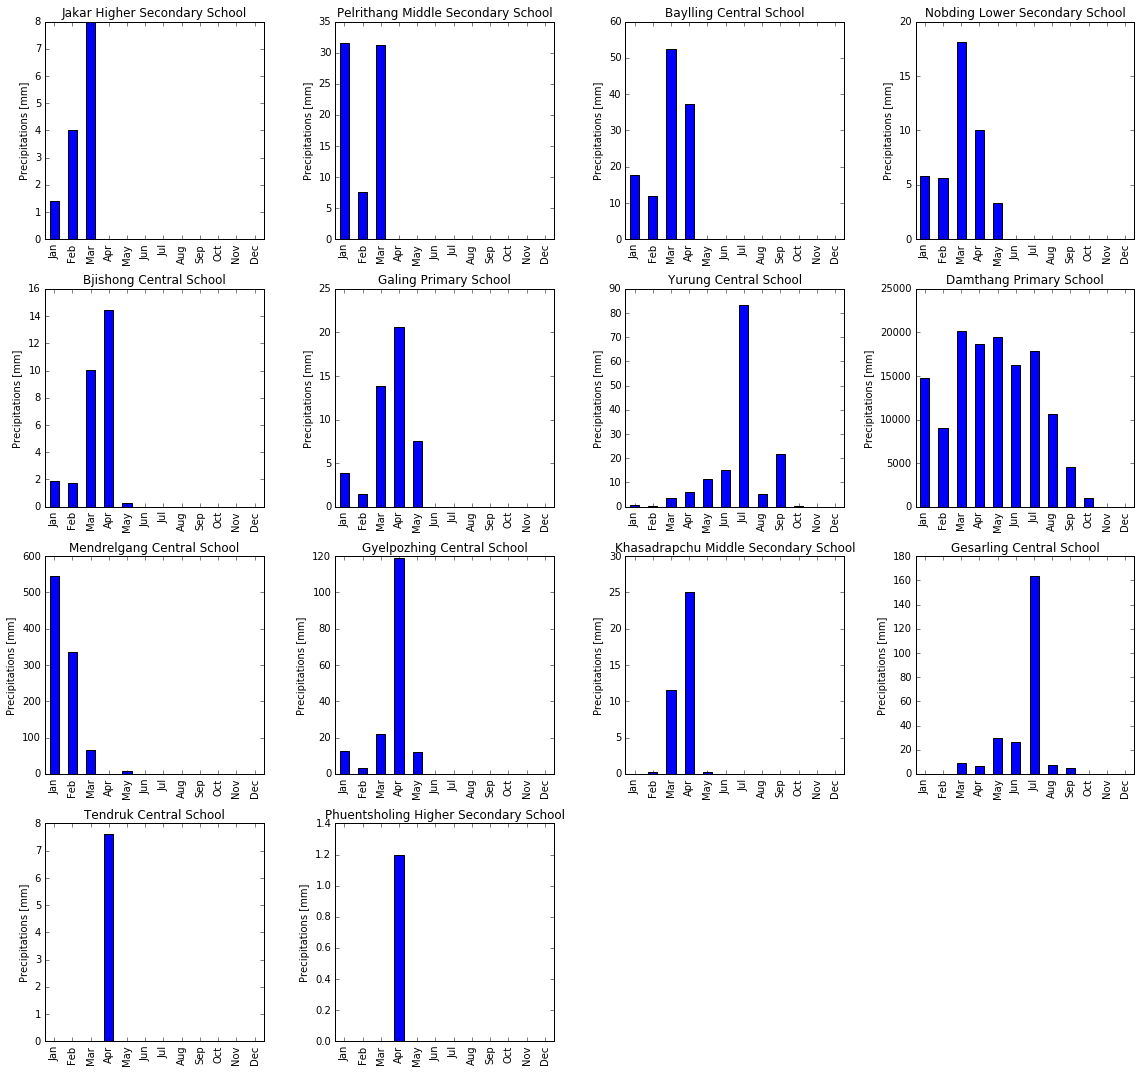

In [7]:
n_rows=4
n_cols=4
fig=plt.figure(figsize=(16,15))
for i, school in enumerate(dfc.school.unique()):
    ax=fig.add_subplot(n_rows,n_cols,i+1)
    dfrain = dfc[dfc.school==school]
    dfrain.set_index('dt', inplace=True)
    dfrain = dfrain.rain
    # first resampling by day by taking the sum of all measurements, then reindexing over the whole year,
    # then resampling by month and taking the monthly sum
    ts = dfrain.resample('D').sum().reindex(pd.date_range('2016-01-01', '2016-12-31')).fillna(0).resample('M').sum()
    ts.plot(kind='bar', ax=ax)
    xticklabels = [idx.strftime('%b') for idx in ts.index]
    xticks = mtick.FixedFormatter(xticklabels)
    ax.xaxis.set_major_formatter(xticks)
    ax.set_title(school)
    ax.set_ylabel('Precipitations [mm]')
fig.tight_layout()
plt.show();

Either we're wrongly interpreting the data, or the sensors yield (wildly) inaccurate values, from much too low to much too high

### Temperature

In [8]:
# custom resamplers to get lowest and highest 5% of distribution, so as to reduce noise
def resampler_5pc(array_like):
    if np.isnan(array_like).all():
        return np.nan
    return np.percentile(array_like[~np.isnan(array_like)], 5)

def resampler_95pc(array_like):
    if np.isnan(array_like).all():
        return np.nan
    return np.percentile(array_like[~np.isnan(array_like)], 95)

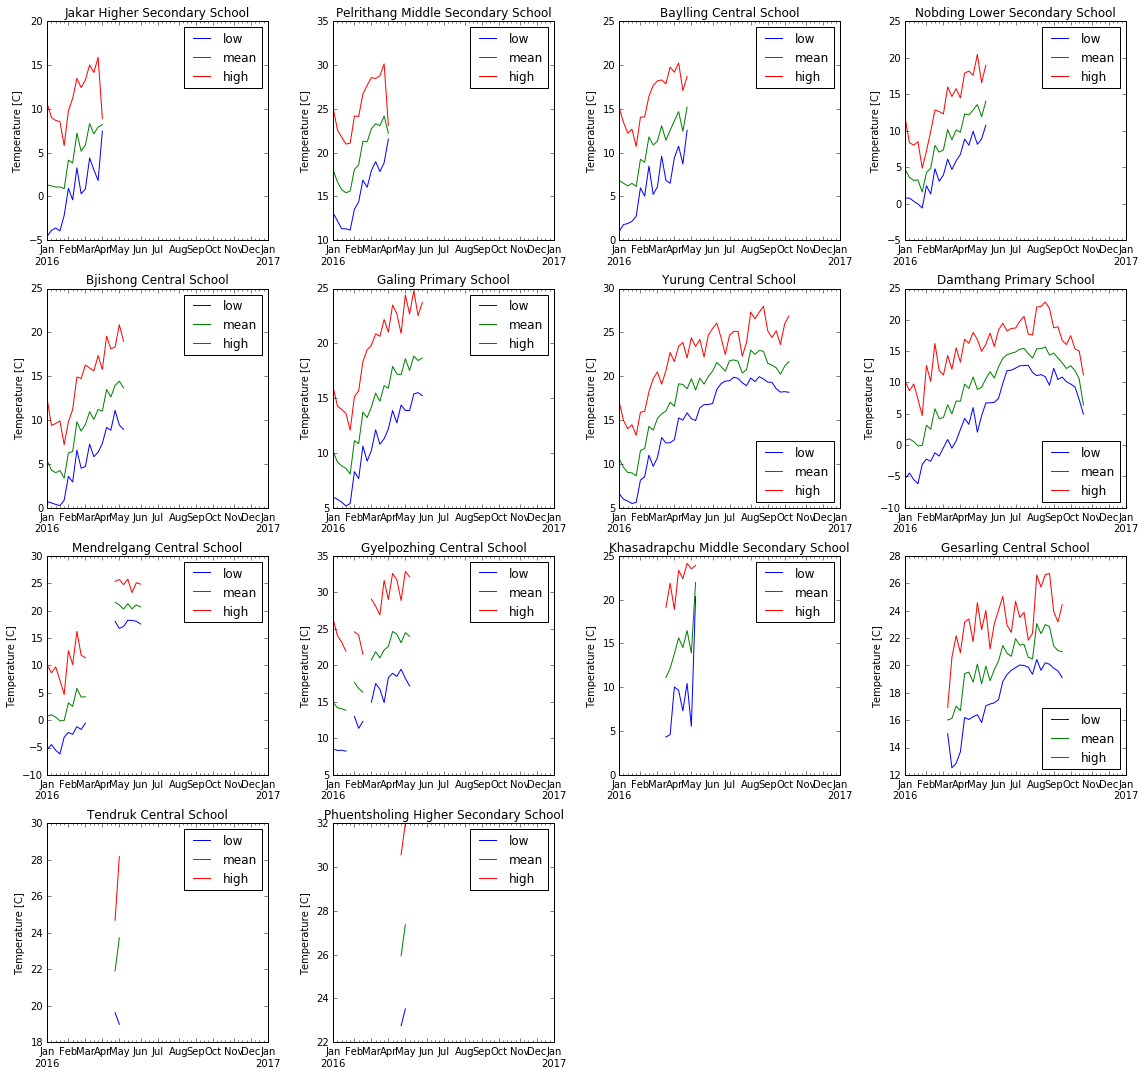

In [9]:
n_rows=4
n_cols=4
fig=plt.figure(figsize=(16,15))
for i, school in enumerate(dfc.school.unique()):
    ax=fig.add_subplot(n_rows,n_cols,i+1)
    dftemp = dfc[dfc.school==school]
    dftemp.set_index('dt', inplace=True)
    dftemp = dftemp.temp
    dftemp_ = pd.DataFrame()
    # first resampling by day with no interpolation for missing values
    tlow = dftemp.resample('D').apply(resampler_5pc)
    tmean = dftemp.resample('D').mean()
    thigh = dftemp.resample('D').apply(resampler_95pc)
    # then averaging by week to get smooth time series
    dftemp_['low'] = tlow.reindex(pd.date_range('2016-01-01', '2016-12-31')).resample('W').mean()
    dftemp_['mean'] = tmean.reindex(pd.date_range('2016-01-01', '2016-12-31')).resample('W').mean()
    dftemp_['high'] = thigh.reindex(pd.date_range('2016-01-01', '2016-12-31')).resample('W').mean()
    dftemp_.plot(ax=ax)
    ax.set_title(school)
    ax.set_ylabel('Temperature [C]')
fig.tight_layout()
plt.show();

The temperature values look fine, but they are very sparse

## Putting phenology and climate measurements together in an interactive graph

Let's focus on a specific school and visualise time series data of observations and climate together. Unfortunately few schools have both many events and many climate measurements, so it will be mostly a proof-of-concept.

In [11]:
school = 'Damthang Primary School'
temp = dfc[dfc.school==school]
temp.set_index('dt', inplace=True)
temp = temp.temp
mtemp = temp.resample('D').mean().reindex(pd.date_range('2016-01-01', '2016-12-31')).resample('W').mean()
htemp = temp.resample('D').apply(resampler_95pc).reindex(pd.date_range('2016-01-01', '2016-12-31')).resample('W').mean()

In [12]:
rh = dfc[dfc.school==school]
rh.set_index('dt', inplace=True)
rh = rh.rh
rh = rh.resample('D').mean().reindex(pd.date_range('2016-01-01', '2016-12-31')).resample('W').mean()

In [13]:
flowers = dfo[(dfo.school_name==school) & (dfo.event_type.isin(['flower', 'flower_bud']))][['event_date']]
flowers = flowers.sort_values(by='event_date')
flowers.set_index('event_date', inplace=True)
flowers['count']=1
flowers = flowers.resample('W').count()

In [14]:
fruits = dfo[(dfo.school_name==school) & (dfo.event_type.isin(['fruit', 'ripe_fruit']))][['event_date']]
fruits = fruits.sort_values(by='event_date')
fruits.set_index('event_date', inplace=True)
fruits['count']=1
fruits = fruits.resample('W').count()

In [15]:
import plotly
import plotly.graph_objs as go
plotly.offline.init_notebook_mode()

In [16]:
trace_mtemp = go.Scatter(
    x = mtemp.index,
    y = mtemp.values,
    mode = 'line',
    name ='Weekly mean temperature (°C)'
)

trace_htemp = go.Scatter(
    x = htemp.index,
    y = htemp.values,
    mode = 'line',
    name ='Weekly high temperature (°C)'
)

trace_rh = go.Scatter(
    x = rh.index,
    y = rh.values,
    mode = 'line',
    name ='Weekly mean relative humidity (%)',
    yaxis='y2'
)

trace_htemp = go.Scatter(
    x = htemp.index,
    y = htemp.values,
    mode = 'line',
    name ='Weekly high temperature (°C)'
)

trace_flowers = go.Scatter(
    x = flowers.index,
    y = [x[0] for x in flowers.values],
    mode = 'line',
    name ='Weekly flowering events'
)

trace_fruits = go.Scatter(
    x = fruits.index,
    y = [x[0] for x in fruits.values],
    mode = 'line',
    name ='Weekly fruiting events'
)

In [17]:
plotly.offline.iplot({'data': [trace_mtemp, trace_htemp, trace_rh, trace_flowers, trace_fruits],
                      'layout': go.Layout(
            title='Temperature and phenology events at %s' % school,
            yaxis=dict(title='Temperature (°C) and event count'),
            yaxis2=dict(title='Relative humidity (%)', overlaying='y', side='right'))
                     }, show_link=False)